# Model Building Analysis
---
---

This notebook carries out the systematic analysis of three regression models —ElasticNet, SVR, and Bayesian Ridge— on microbiome-based data.

The workflow follows a structured progression through:
1. Training and evaluating **baseline models** using the full feature set.
2. Applying **feature selection** to reduce dimensionality and improve stability.
3. Performing **hyperparameter tuning** to optimize model performance.
4. Comparing models across phases using **evaluation metrics** and **boxplots**.
5. Saving the best models in a dedicated directory and identifying the **best overall model**.
6. Training a **final model** on the entire dataset for submission using a reproducible pipeline.

All experiments ensure reproducibility with a fixed seed and save trained models at each stage.

---
---

## 1. Baseline Models 
We will train three regression models on the complete development dataset and evaluate their performance using the evaluation set. To ensure robust and meaningful statistics, the evaluation process will be repeated multiple times. This will be achieved using the `bootstrap` strategy, a resampling technique that involves randomly sampling the original dataset with replacement to create multiple new datasets.

In [1]:
# ------------- Setup and Imports -------------
import pandas as pd
import numpy as np
import os
import sys

sys.path.append("../")

from src.functions import *
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

# Seed for reproducibility
np.random.seed(42)

In [2]:
import importlib
import src.functions as functions
importlib.reload(functions)

from src.functions import *  # reload the updated functions


In [3]:
# ------------- Load Datasets -------------
dev_df = load_dataset("../data/development_final_data.csv")
val_df = load_dataset("../data/evaluation_final_data.csv")


# ------------- Split target and features -------------
X_dev, y_dev = split_features_target(dev_df, 'BMI')
X_val, y_val = split_features_target(val_df, 'BMI')


# ------------- Directories for Saving Models -------------
os.makedirs("../models", exist_ok=True)
os.makedirs("../final_models", exist_ok=True)

In [4]:
### ------------- BASELINE MODELS -------------

# Initialize models with default hyperparameters 
models = {'ElasticNet_baseline' : ElasticNet(),
          'SVR_baseline' : SVR(),
          'BayesianRidge_baseline' : BayesianRidge()}

baseline_results = {}
baseline_scores = {}


for name, model in models.items():

    # 1. Using `train_model` function to train the model
    trained_model = train_model(X_dev, y_dev, model)

    # 2. Using `save_model` function to save the model
    save_model(trained_model, f"../models/{name}.joblib")

    # 3. Using `evaluate_model` function to evaluate on full evaluation set
    full_metrics = evaluate_model(trained_model, X_dev, y_dev, X_val, y_val)
    print(f"The metrics on full dataset for the model {name} are\n {pd.DataFrame([full_metrics])}\n")

    # 4. Using `bootstrap_evaluation` function to repeat the evaluation multiple times in the eval set
    bootstrap_summary, bootstrap_scores = bootstrap_evaluation(trained_model, X_val, y_val, n_iterations=100)
    baseline_results[name] = bootstrap_summary
    baseline_scores[name] = bootstrap_scores

# ------------- Baseline Results to DataFrame -------------
baseline_summary = bootstrap_dataframe(baseline_results)
print(baseline_summary)

The metrics on full dataset for the model ElasticNet_baseline are
    train_rmse  train_mae  train_r2  test_rmse  test_mae   test_r2
0         1.0   0.653775       0.0   0.946902  0.680027 -0.001216

The metrics on full dataset for the model SVR_baseline are
    train_rmse  train_mae  train_r2  test_rmse  test_mae   test_r2
0    0.757553   0.306256  0.426114   0.855728  0.554217  0.182309

The metrics on full dataset for the model BayesianRidge_baseline are
    train_rmse  train_mae  train_r2  test_rmse  test_mae   test_r2
0    0.869511   0.521143  0.243951   0.871778  0.599233  0.151348

                        RMSE_mean  RMSE_median  RMSE_ci_low  RMSE_ci_high  \
ElasticNet_baseline      0.938703     0.930246     0.821091      1.070655   
SVR_baseline             0.851810     0.845228     0.736131      0.994263   
BayesianRidge_baseline   0.867513     0.855049     0.762734      1.005117   

                        MAE_mean  MAE_median  MAE_ci_low  MAE_ci_high  \
ElasticNet_baseline   

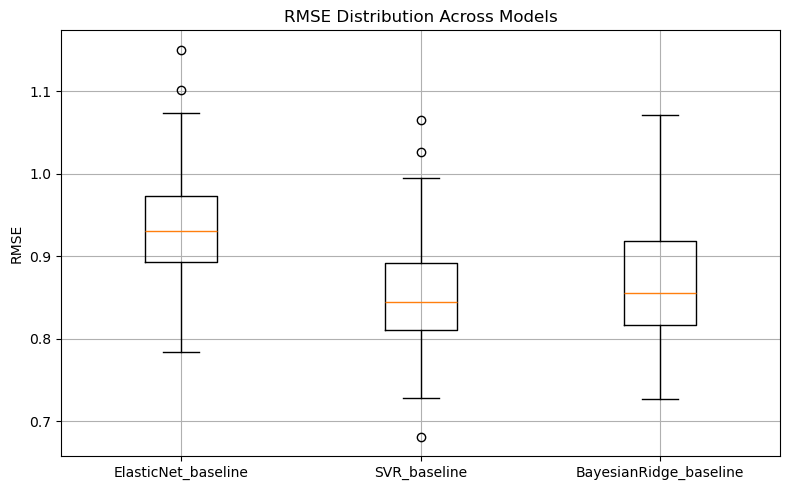

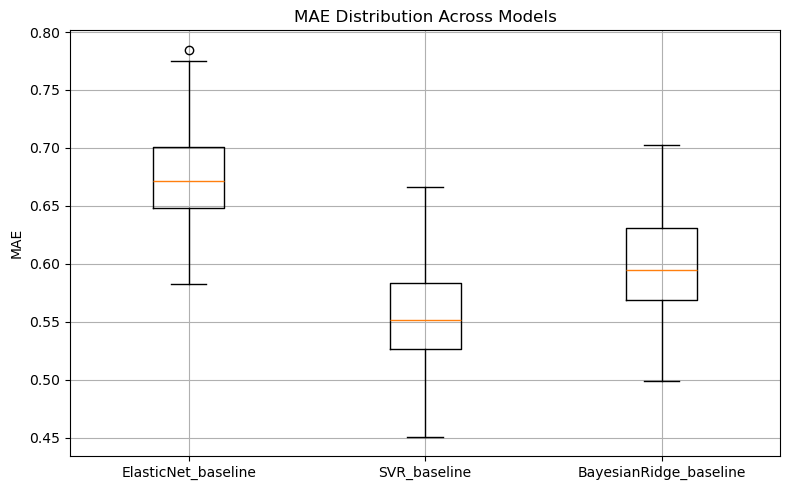

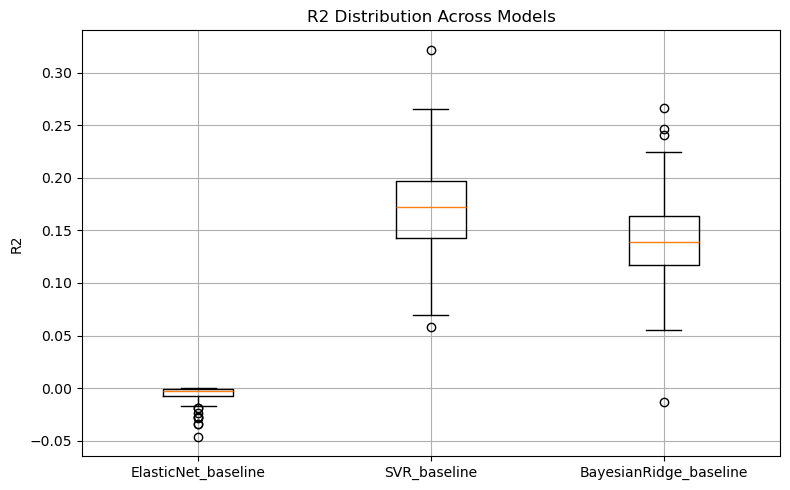

In [5]:
# ------------- Plotting Metrics of Baseline Models -------------
plot_metrics_boxplot(baseline_scores)

## 2. Feature Selection Models
To improve models performance and interpretability -including nonlinear ones like SVR-, we will apply feature selection strategy using a combination of filter-based and wrapper-based techniques. THe filter-based approach will be applied using the `F-regression` to all models to remove features with low univariate correlation to the target variable. For the `SVR` model, we will further apply wrapper-based feature selection using `Sequential Feature Selection (SFS)`. This automated method is being chosen because it lets the model itself determine the most informative subset of features, and no arbitrary selection is being performed. 

Benchmarking showed that SVR benefited from both filtering and wrapper-based selection methods, while the others not. So, we apply the wrapper-based method only to the respective model. 

In [6]:
### ------------- FEATURE SELECTION MODELS -------------

# Initialize models with default hyperparameters 
models = {'ElasticNet_FS' : ElasticNet(),
          'SVR_FS' : SVR(),
          'BayesianRidge_FS' : BayesianRidge()}

FS_resluts = {}
FS_scores = {}
selected_features_dict = {}

# Filter-based Feature Selection Method for all models
X_dev_filt, filtered_features = filter_fs(X_dev, y_dev)
X_val_filt = X_val[filtered_features]

for name, model in models.items():

    # 1. Using `select_features_sfs` function to select features for SVR model
    if name == 'SVR_FS':
        X_dev_fs, selected_features = select_features_sfs(model, X_dev_filt, y_dev)
        X_val_fs = X_val[selected_features]

    else:
        X_dev_fs = X_dev_filt
        X_val_fs = X_val_filt
        selected_features = filtered_features

    selected_features_dict[name] = selected_features


    # 2. Using `train_model` function to train the model
    trained_model = train_model(X_dev_fs, y_dev, model)

    # 3. Using `save_model` function to save the model
    save_model(trained_model, f"../models/{name}.joblib")

    # 4. Using `evaluate_model` function to evaluate on full evaluation set
    full_metrics = evaluate_model(trained_model, X_dev_fs, y_dev, X_val_fs, y_val)
    print(f"The metrics on full dataset for the model {name} are\n {pd.DataFrame([full_metrics])}\n")

    # 5. Using `bootstrap_evaluation` function to repeat the evaluation multiple times in the eval set
    bootstrap_summary, bootstrap_scores = bootstrap_evaluation(trained_model, X_val_fs, y_val, n_iterations=100)
    FS_resluts[name] = bootstrap_summary
    FS_scores[name] = bootstrap_scores

# ------------- FS Results to DataFrame -------------
FS_summary = bootstrap_dataframe(FS_resluts)
print(FS_summary)

The metrics on full dataset for the model ElasticNet_FS are
    train_rmse  train_mae  train_r2  test_rmse  test_mae   test_r2
0         1.0   0.653775       0.0   0.946902  0.680027 -0.001216



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.9s
Features: 1/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.6s
Features: 2/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.7s
Features: 3/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.5s
Features: 4/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
Features: 5/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.7s
Features: 6/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
Features: 7/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
Features: 8/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
Features: 9/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
Features: 10/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.5s
Features: 11/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
Features: 12/50[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.7s
Features: 13/50[Parallel(n_jobs=1)]:

The metrics on full dataset for the model SVR_FS are
    train_rmse  train_mae  train_r2  test_rmse  test_mae   test_r2
0    0.770973   0.347262  0.405601   0.846818    0.5736  0.199248

The metrics on full dataset for the model BayesianRidge_FS are
    train_rmse  train_mae  train_r2  test_rmse  test_mae   test_r2
0    0.866504   0.520188  0.249171   0.862597  0.593115  0.169129

                  RMSE_mean  RMSE_median  RMSE_ci_low  RMSE_ci_high  MAE_mean  \
ElasticNet_FS      0.938703     0.930246     0.821091      1.070655  0.675721   
SVR_FS             0.842315     0.838894     0.740935      0.959319  0.572743   
BayesianRidge_FS   0.857787     0.844823     0.752453      0.996638  0.593106   

                  MAE_median  MAE_ci_low  MAE_ci_high   R2_mean  R2_median  \
ElasticNet_FS       0.671339    0.602172     0.761015 -0.006313  -0.002661   
SVR_FS              0.569381    0.489369     0.634789  0.188005   0.189259   
BayesianRidge_FS    0.585976    0.524662     0.670988  0.

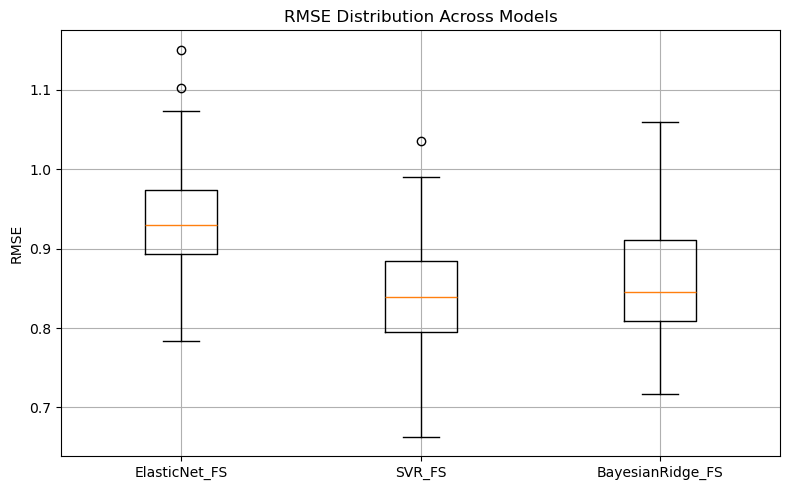

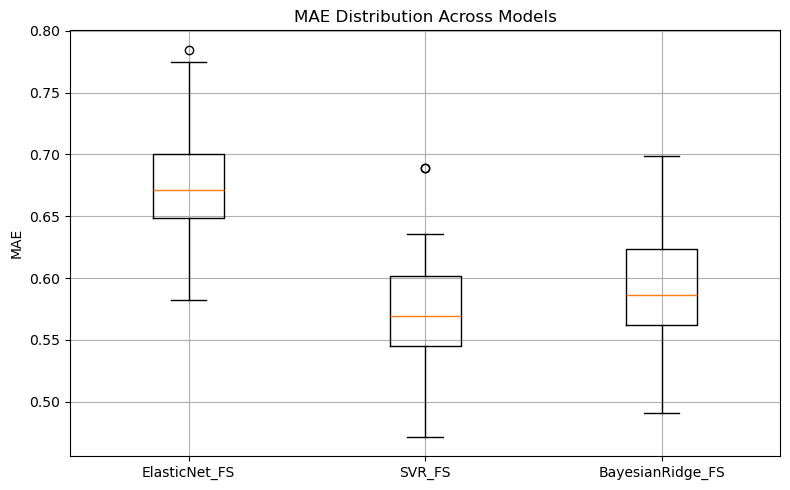

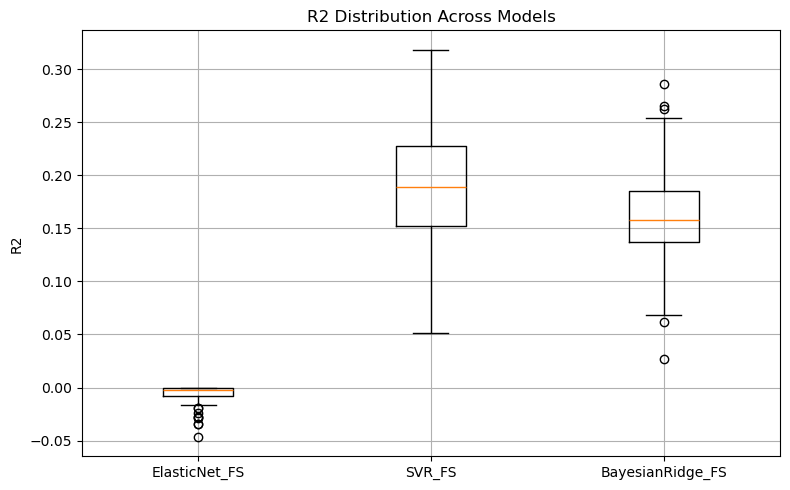

In [7]:
# ------------- Plotting Metrics of FS Models -------------
plot_metrics_boxplot(FS_scores)

## 3. Hyperparameter Tuning Models

For each model, we will define a hyperparameter grid based on commonly used ranges from the scikit-learn documentation and related literature in predictive modeling. For `ElasticNet`, we will vary `alpha` and `l1_ratio` across ranges that span weak to strong regularization. For `SVR`, we will explore different settings for `C` (regularization), `epsilon` (sensitivity), and `gamma`, enabling both tight and flexible fits. For `BayesianRidge`, we will tune the hyperparameters `alpha_1`, `alpha_2`, `lambda_1`, `lambda_2`. A 5-fold cross-validation strategy will be applied to identify the best combination based on RMSE.


In [8]:
### ------------- HYPERPARAMETER TUNING MODELS -------------

# Initialize models with default hyperparameters 
models = {'ElasticNet' : ElasticNet(),
          'SVR' : SVR(),
          'BayesianRidge' : BayesianRidge()}

tuning_results = {}
tuning_results_scores = {}

# Define the hyperparameter grid for tuning
param_grids = {
    'ElasticNet' : {
        'alpha' : [0.01, 0.1, 1.0, 10.0],
        'l1_ratio' : [0.1, 0.5, 0.9, 1.0]
    },
    'SVR' : {
        'C' : [0.1, 1.0, 10.0],
        'gamma' : ['scale', 'auto'],
        'epsilon' : [0.01, 0.1, 0.5]
    },
    'BayesianRidge': {
        'alpha_1': [1e-6, 1e-5, 1e-4],
        'alpha_2': [1e-6, 1e-5, 1e-4],
        'lambda_1': [1e-6, 1e-5, 1e-4],
        'lambda_2': [1e-6, 1e-5, 1e-4]
    }
}


# Remove the '_FS' suffix from the selected features
selected_features_dict = {
    name.replace('_FS', ''): feats for name, feats in selected_features_dict.items()
}

for name, model in models.items():

    # 1. Define param_grid for the model
    param_grid = param_grids[name]

    # 2. Using selected_features from the previous step
    selected_feats = selected_features_dict[name]
    X_dev_fs = X_dev[selected_feats]
    X_val_fs = X_val[selected_feats]

    # 3. Tune and train the model using `tune_model` function
    tuned_model = tune_model(model, X_dev_fs, y_dev, param_grid)

    # 4. Using `save_model` function to save the model
    save_model(trained_model, f"../models/{name}_tuned.joblib")

    # 4. Using `evaluate_model` function to evaluate on full evaluation set
    full_metrics = evaluate_model(tuned_model, X_dev_fs, y_dev, X_val_fs, y_val)
    print(f"The metrics on full dataset for the model {name} are\n {pd.DataFrame([full_metrics])}\n")

    # 5. Using `bootstrap_evaluation` function to repeat the evaluation multiple times in the eval set
    bootstrap_summary, bootstrap_scores = bootstrap_evaluation(tuned_model, X_val_fs, y_val, n_iterations=100)
    tuning_results[name] = bootstrap_summary
    tuning_results_scores[name] = bootstrap_scores

# ------------- Hyperparameter Tuning Results to DataFrame -------------
tuning_summary = bootstrap_dataframe(tuning_results)
print(tuning_summary)


 Tuning: ElasticNet
 Grid size: 8 total params
 Dataset shape: 489 samples, 107 features
 Best parameters: {'alpha': 1.0, 'l1_ratio': 0.1}
 Best CV score: 0.9825
The metrics on full dataset for the model ElasticNet are
    train_rmse  train_mae  train_r2  test_rmse  test_mae   test_r2
0    0.964183    0.62428  0.070351   0.925424  0.657534  0.043689


 Tuning: SVR
 Grid size: 8 total params
 Dataset shape: 489 samples, 43 features
 Best parameters: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale'}
 Best CV score: 0.8946
The metrics on full dataset for the model SVR are
    train_rmse  train_mae  train_r2  test_rmse  test_mae   test_r2
0    0.770973   0.347262  0.405601   0.846818    0.5736  0.199248


 Tuning: BayesianRidge
 Grid size: 12 total params
 Dataset shape: 489 samples, 107 features
 Best parameters: {'alpha_1': 1e-06, 'alpha_2': 0.0001, 'lambda_1': 0.0001, 'lambda_2': 0.0001}
 Best CV score: 0.9640
The metrics on full dataset for the model BayesianRidge are
    train_rmse  train

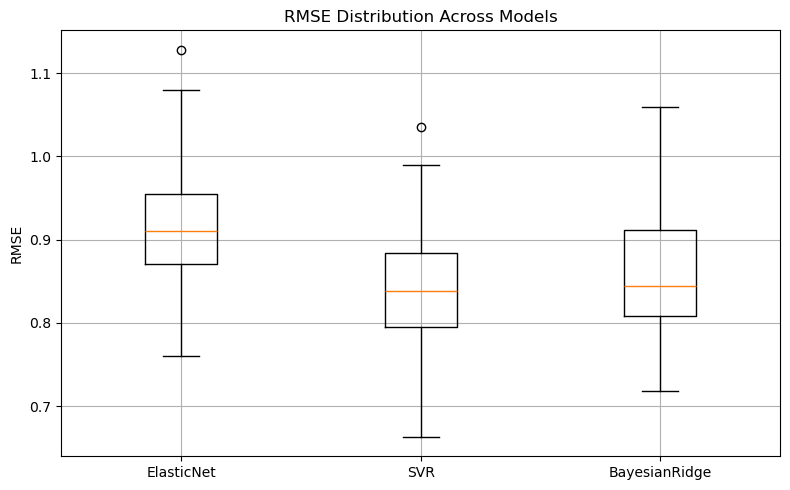

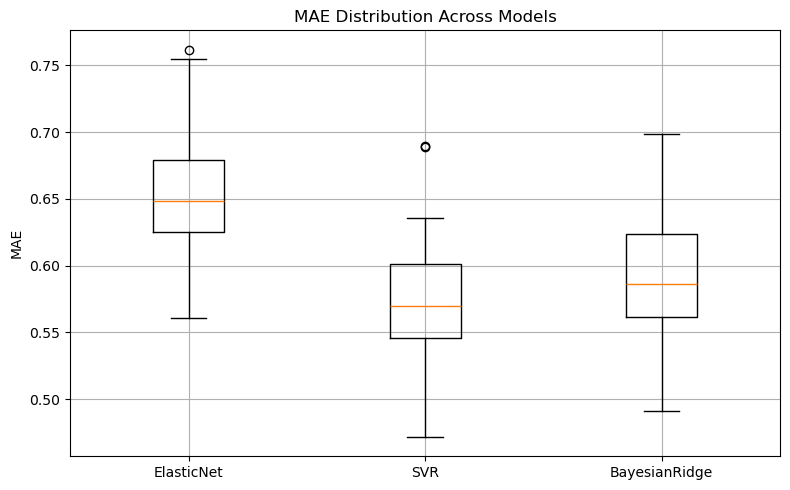

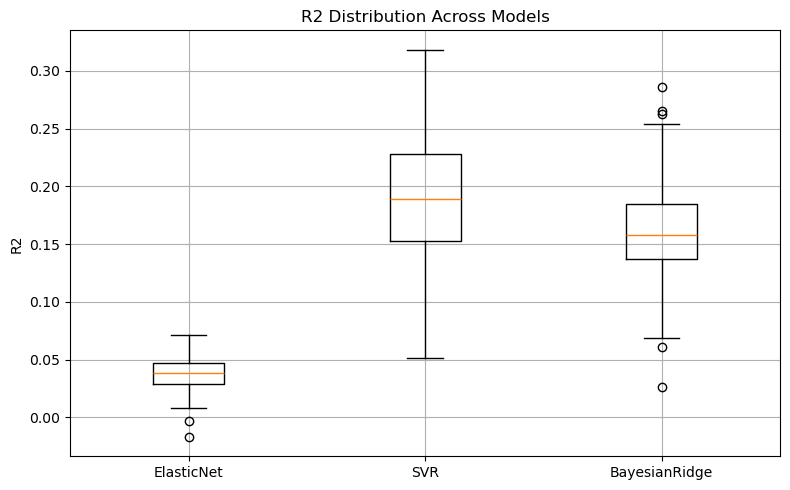

In [9]:
plot_metrics_boxplot(tuning_results_scores)

## 4. Comparing all models to find the winner!

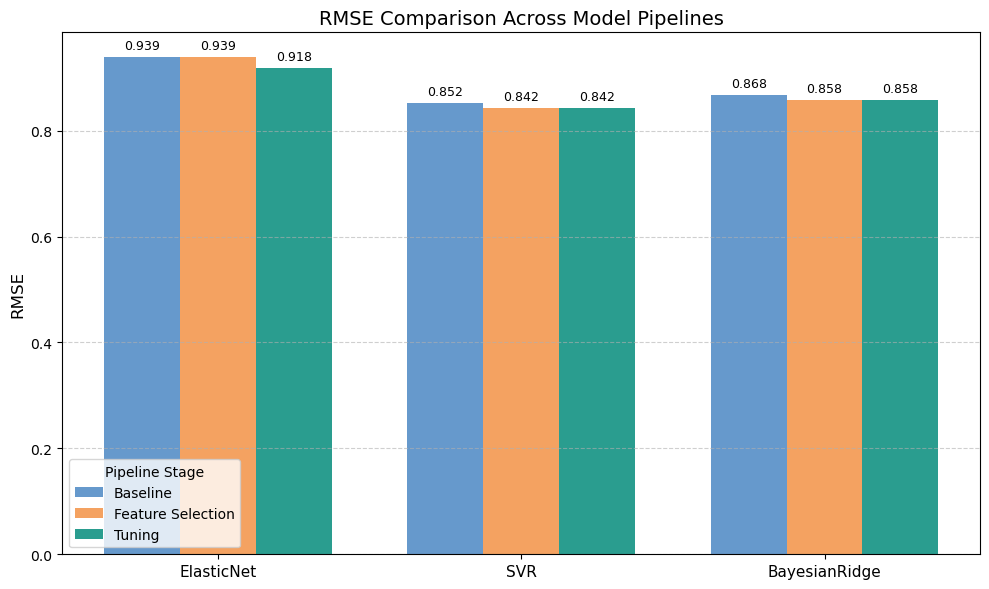

In [10]:
# ------------- Plotting Metrics of Models -------------

# Put all score dictionaries in one place
all_scores = {
    'ElasticNet': {
        'Baseline': baseline_scores['ElasticNet_baseline']['RMSE'],
        'Feature Selection': FS_scores['ElasticNet_FS']['RMSE'],
        'Tuning': tuning_results_scores['ElasticNet']['RMSE']
    },
    'SVR': {
        'Baseline': baseline_scores['SVR_baseline']['RMSE'],
        'Feature Selection': FS_scores['SVR_FS']['RMSE'],
        'Tuning': tuning_results_scores['SVR']['RMSE']
    },
    'BayesianRidge': {
        'Baseline': baseline_scores['BayesianRidge_baseline']['RMSE'],
        'Feature Selection': FS_scores['BayesianRidge_FS']['RMSE'],
        'Tuning': tuning_results_scores['BayesianRidge']['RMSE']
    }
}

# Colors for each pipeline stage
colors = {
    'Baseline': '#6699cc',
    'Feature Selection': '#f4a261',
    'Tuning': '#2a9d8f'
}

# Prepare data for plotting
regressors = list(all_scores.keys())
stages = list(colors.keys())

# Bar width and positions
bar_width = 0.25
x = np.arange(len(regressors))  # base positions for each regressor

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each stage side-by-side
for i, stage in enumerate(stages):
    means = [np.mean(all_scores[reg][stage]) for reg in regressors]
    bar_pos = x + (i - 1) * bar_width  # center the middle one
    bars = ax.bar(bar_pos, means, width=bar_width, label=stage, color=colors[stage])
    
    # Add values on top of bars
    for rect in bars:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, height + 0.01, f"{height:.3f}",
                ha='center', va='bottom', fontsize=9)

# Customize plot
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('RMSE Comparison Across Model Pipelines', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(regressors, fontsize=11)
ax.legend(title='Pipeline Stage')
ax.grid(True, linestyle='--', alpha=0.6, axis='y')
plt.tight_layout()
plt.show()


In [11]:
# Load best-performing models from the previous steps
ElasticNet_best = load_model("../models/ElasticNet_tuned.joblib")
SVR_best = load_model("../models/SVR_tuned.joblib")
BayesianRidge_best = load_model("../models/BayesianRidge_FS.joblib")

# Saving best models instances using `save_model` function
save_model(ElasticNet_best, "../final_models/ElasticNet_tuned.joblib")
save_model(SVR_best, "../final_models/SVR_tuned.joblib")
save_model(BayesianRidge_best, "../final_models/BayesianRidge_FS.joblib")

Although SVR demonstrated the best predictive accuracy, its interpretability is limited compared to linear models like ElasticNet or Bayesian Ridge. For scenarios where model transparency is crucial — such as biomarker discovery or hypothesis generation — Bayesian Ridge may be preferred despite a slight drop in performance. However, for pure prediction tasks, SVR is the optimal choice.

## 5. Training the best overall model instance on the whole dataset.

In [12]:
# 1. Load raw datasets and drop metadata columns
dev_df = pd.read_csv('~/Assignment-1/data/assignment1_dev_set.csv')
val_df = pd.read_csv('~/Assignment-1/data/assignment1_val_set.csv')

metadata_columns = ["Project ID", "Experiment type", "Host age", "Sex", "Disease MESH ID"]
dev_df = dev_df.drop(columns=metadata_columns)
val_df = val_df.drop(columns=metadata_columns)

# 2. Combine datasets
df_all = pd.concat([dev_df, val_df], axis=0)


# 3. Define the automated pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('log1p', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())])

# 4. Fit the preprocessing pipeline
df_all = preprocessing_pipeline.fit_transform(df_all)
df_all = pd.DataFrame(df_all, columns=dev_df.columns, index=dev_df.index.append(val_df.index))

# 5. Split target and features
X_all, y_all = split_features_target(df_all, 'BMI')

# 6. Apply filter-based feature selection
X_all_filt, filtered_features = filter_fs(X_all, y_all)

# 7. Train the best model on the entire dataset
final_model = BayesianRidge()
final_model.fit(X_all_filt, y_all)

# 8. Save the final model
save_model(final_model, "../final_models/winner.joblib")

---
---